In [25]:
%run Function_Master.ipynb 
%run Parameterization.ipynb

## Defining Parameterization and Initial Conditions

In [20]:
print_parameterization(param)

╒════════════════════════════════════════╤═══════════════╤═════════════════╤═══════════════╤══════════════════════╕
│ V_max = 1.4                            │ λ_P = 0.05    │ μ_V = 0.5       │ μ_P = 0.4     │ K_I = 1.0            │
├────────────────────────────────────────┼───────────────┼─────────────────┼───────────────┼──────────────────────┤
│ γ_Z = 0.4                              │ λ_Z = 0.05    │ μ_V_prime = 1.0 │ μ_delta = 0.4 │ K_h = 1.0            │
├────────────────────────────────────────┼───────────────┼─────────────────┼───────────────┼──────────────────────┤
│ φ = 110236.2205                        │ λ_Z_hat = 0.1 │ μ_u = 0.0       │ μ_g = 0.4     │ K_P = 2.8            │
├────────────────────────────────────────┼───────────────┼─────────────────┼───────────────┼──────────────────────┤
│ g = 1.4                                │ λ_E = 0.5     │ μ_r = 0.5       │ μ_Z = 0.4     │ I_0 = e - 1 = 1.7183 │
├────────────────────────────────────────┼───────────────┼──────────────

## Running and Sorting Simulations

In [21]:
"""
Defines certain criteria for the numerical integration scheme.

Individual tolerances are perscribed to each state based on knowledge of
their probable values.
"""
t_span = 850

# Total N span
points = 200
N_t = np.logspace(-4, 1, points) * 2

max_step   = .1
method     = 'LSODA'
tolerances = [1e-8, 1e-8, 1e-12, 1e-8, 1e-8, 1e-10, 1e-10]

In [22]:
%%time

"""
This cell defines the level for which each state shall be initialized based
on a reasonable ratio of total nutrients as nutrients increase in the system.

Numerically integrating equations for each initial condition configuration. 
"""
sols = []

Nn_0 = 0.
Pi_0 = 0.
Vi_0 = 0.

for Nt in N_t:
    
    # Define Phytoplankton and Zooplankton as certain percentages
    Pu_0 = .1 * Nt  
    Z_0  = .2 * Nt 
    
    #Initial level of Ve is computed based on the ratio of hosts to viruses
    r = 1/10
    Ve_0 = est_viral_abund(r, Pu_0, alpha, beta, S_ind, V_ind)
    
    # Define nutrient level as the remainder
    Nr_0 = Nt - (Pu_0 + Z_0 + Ve_0)
    
    # Define initial condition array
    z0 = [Nn_0, Nr_0, Pu_0, Pi_0, Z_0, Vi_0, Ve_0]
    
    solution = solve_ivp(model, [0, t_span], z0, args=param,
                         max_step=max_step, method=method, atol=tolerances)     
    
    #returns list of initial conditions + solution object
    sols.append((z0, solution))

len(sols)

CPU times: user 11.4 s, sys: 282 ms, total: 11.6 s
Wall time: 11.7 s


200

In [23]:
%store sols

Stored 'sols' (list)


In [1]:
%store -r sols

In [26]:
# Filtering solutions into different groups

ss_sols = []
osc_sols = []

for z0, sol in sols: 
    info = ss_or_osc(sol)
    
    if info == 'osc':
        osc_sols.append([z0, sol])
        
    else:
        ss_sols.append([z0, sol] + list(info))
        
print(f'Out of {len(sols)} solutions, {len(ss_sols)} are steady (or decay) and {len(osc_sols)} are oscillatory.')

Out of 200 solutions, 181 are steady (or decay) and 19 are oscillatory.


## Quick Visualization

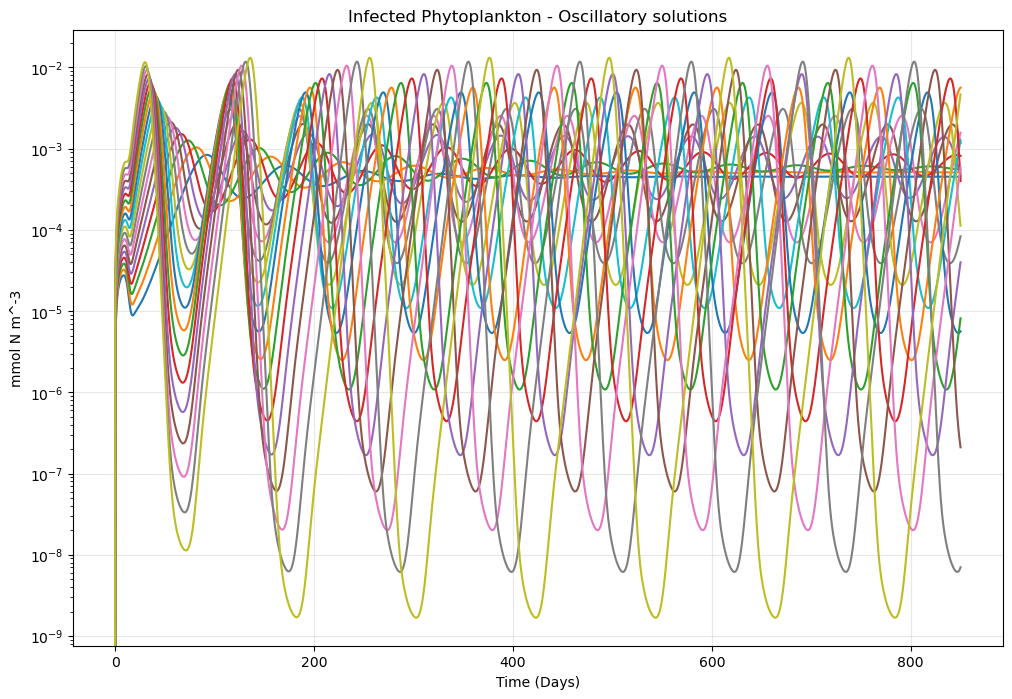

In [33]:
plt.figure(figsize=(12, 8))

for z0, sol in osc_sols: 
    plt.plot(sol.t, sol.y[3])

    
plt.title('Infected Phytoplankton - Oscillatory solutions')
plt.xlabel('Time (Days)')
plt.ylabel('mmol N m^-3')

plt.grid(alpha=.3)

plt.yscale('log')
# plt.ylim(1e-12, 1)

plt.show()

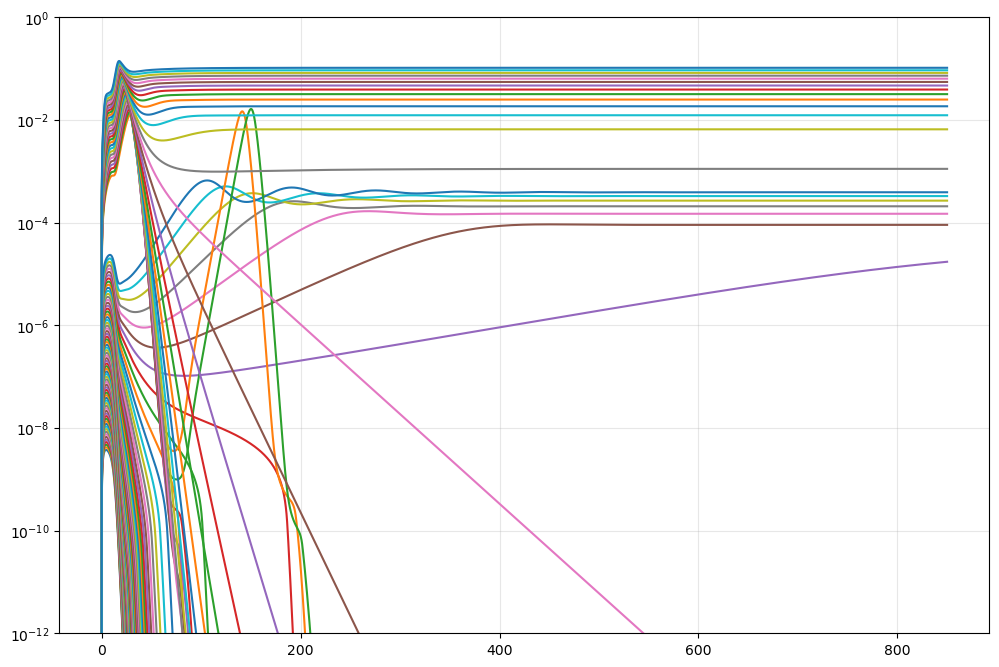

In [31]:
plt.figure(figsize=(12, 8))

for z0, sol, ss, conv_ind in ss_sols: 
    if sum(z0) < .2:
        plt.plot(sol.t, sol.y[3])

plt.grid(alpha=.3)
plt.yscale('log')
plt.ylim(1e-12, 1)
plt.show()

## Host:Virus ratio and burst size wrt total N

In [21]:
# make data set

data = []

for z0, sol, ss, conv_index in ss_sols:
    
    ss_Nn, ss_Nr, ss_Pu, ss_Pi, ss_Z, ss_Vi, ss_Ve = ss
    
    # Ratio of individual extracellular viruses to collective phytoplankton
    r = est_viral_ratio(ss_Ve, (ss_Pu + ss_Pi), alpha, beta, S_ind, V_ind)
    
    # Number of individual intracellular viruses per infected host
    burst_size = 1 / est_viral_ratio(ss_Vi, ss_Pi, alpha, beta, S_ind, V_ind)

        
    data.append([sum(z0), ss_Nr, ss_Pu, ss_Pi, ss_Z, ss_Vi, ss_Ve, 1/r, burst_size])
    
df = pd.DataFrame(data, columns = ['Total N', 'SS N_r', 'SS P_U', 'SS P_I', 'SS Z', 'SS V_I', 'SS V_E', 'Free V_E : Phyto', 'Burst Size'])

/var/folders/t4/0522k7j90ms45_0szysm1s4h0000gn/T/ipykernel_84636/1549650791.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  burst_size = 1 / est_viral_ratio(ss_Vi, ss_Pi, alpha, beta, S_ind, V_ind)


In [25]:
# Want to filter out solutions where infected phytoplankton aren't alive

filtered_df = df[df['SS P_I'] > 1e-12]
filtered_df.describe()

,Total N,SS N_r,SS P_U,SS P_I,SS Z,SS V_I,SS V_E,Free V_E : Phyto,Burst Size
count,1011.000000,1011.000000,1.011000e+03,1.011000e+03,1.011000e+03,1.011000e+03,1.011000e+03,1011.000000,1011.000000
mean,3.430233,1.795769,2.589531e-04,6.754592e-01,9.578655e-01,6.096840e-04,2.705177e-04,178.723563,339.097272
std,4.775139,3.548153,9.590934e-04,5.609283e-01,1.011461e+00,3.612344e-04,2.298405e-04,173.899412,247.486784
min,0.007931,0.003704,-5.178549e-64,3.009310e-12,1.120283e-21,1.279272e-14,8.700149e-15,0.002392,40.817102
25%,0.254879,0.090996,0.000000e+00,1.628245e-01,1.287312e-08,3.733540e-04,5.794681e-05,8.481328,59.922014
50%,1.091185,0.122713,0.000000e+00,4.882283e-01,4.786164e-01,5.365828e-04,1.903839e-04,109.712961,350.351594
75%,4.671604,1.125769,0.000000e+00,1.348094e+00,2.197165e+00,1.007874e-03,5.113684e-04,399.313405,636.194059
max,20.000000,16.019897,4.299424e-03,1.492981e+00,2.486700e+00,1.085241e-03,6.317296e-04,478.052184,702.929172


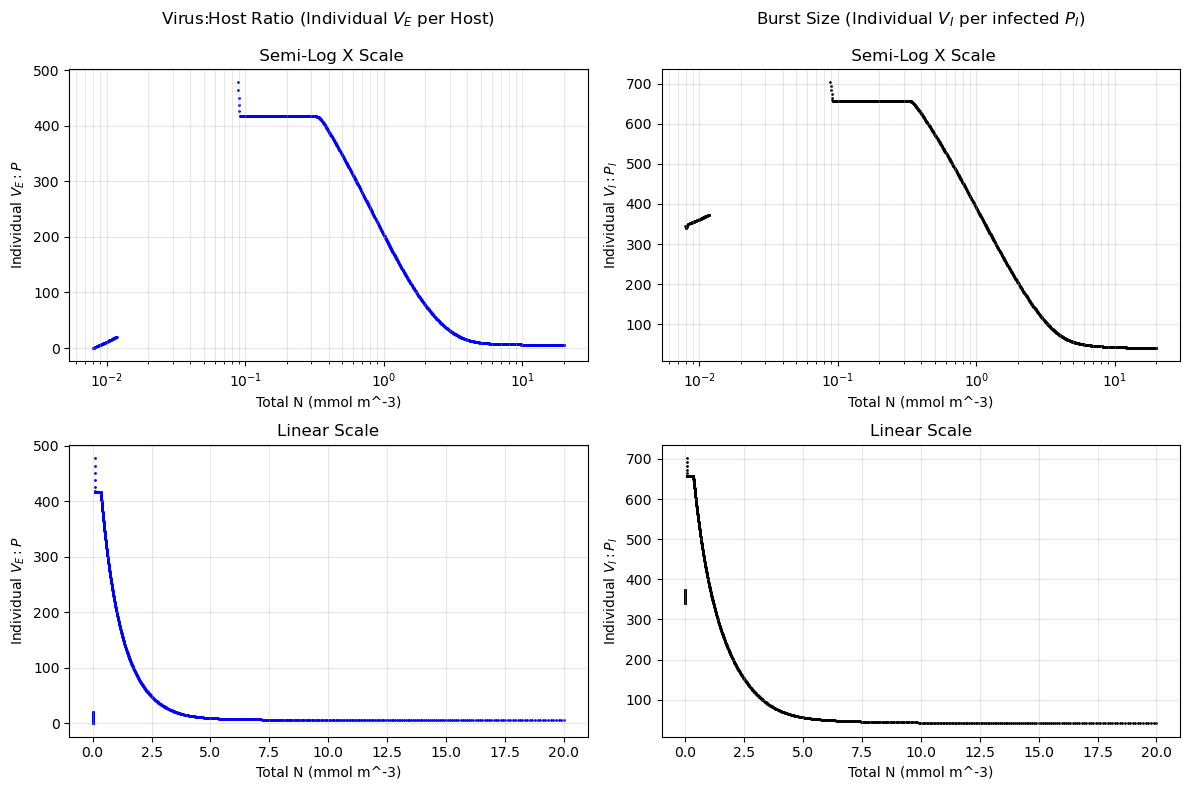

In [26]:
# CONCENTRATION BASED PLOT 

# fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# axs[0].scatter(filtered_df['Total N'], filtered_df['SS V_E']/(filtered_df['SS P_U'] + filtered_df['SS P_I']), color='purple', s=2)
# axs[0].set_title('Concentration Extracellular Virus:Host Ratio')
# axs[0].set_ylabel('V_E / P')

# # Linear axs[0] plot settings
# # axs[0].set_ylim(0, 1500)

# # Log axs[0] plot settings
# # axs[0].set_yscale('log')
# # axs[0].set_ylim(1e-12, 1e5)

# axs[1].scatter(filtered_df['Total N'],  filtered_df['SS V_I']/filtered_df['SS P_I'], color='purple', s=2)
# axs[1].set_title('Concentration V_I:P_I Ratio')
# axs[1].set_ylabel('V_I / P_I')
# # axs[1].set_ylim(0, 1100)

# for ax in axs:
#     ax.set_xlabel('Total N (mmol m^-3)')
#     #ax.set_xscale('log')
#     ax.grid(which='both', alpha=.3)
    
# plt.tight_layout()
# plt.show()


####################################################################################################
# INDIVIDUAL BASED PLOT

fig, axs = plt.subplots(2, 2, figsize=(12, 8))


axs[0][0].scatter(filtered_df['Total N'], filtered_df['Free V_E : Phyto'], color='blue', s=1)
axs[0][0].set_title(r'Virus:Host Ratio (Individual $V_E$ per Host)'
                    '\n\n Semi-Log X Scale')

axs[0][0].set_ylabel(r'Individual $V_E : P$')
axs[0][0].set_xscale('log')

axs[1][0].scatter(filtered_df['Total N'], filtered_df['Free V_E : Phyto'], color='blue', s=1)
axs[1][0].set_title('Linear Scale')
axs[1][0].set_ylabel(r'Individual $V_E : P$')


# Linear axs[0] plot settings
# axs[0].set_ylim(0, 1500)

# Log axs[0] plot settings
# axs[0].set_yscale('log')
# axs[0].set_ylim(1e-12, 1e5)

axs[0][1].scatter(filtered_df['Total N'], filtered_df['Burst Size'], color='black', s=1)
axs[0][1].set_title(r'Burst Size (Individual $V_I$ per infected $P_I$)'
                    '\n\n Semi-Log X Scale')
axs[0][1].set_ylabel(r'Individual $V_I : P_I$')
axs[0][1].set_xscale('log')
# axs[1].set_ylim(0, 1100)

axs[1][1].scatter(filtered_df['Total N'], filtered_df['Burst Size'], color='black', s=1)
axs[1][1].set_title('Linear Scale')
axs[1][1].set_ylabel(r'Individual $V_I : P_I$')

for ax in axs.reshape(-1):
    # ax.set_ylim(-100, 1300)
    
    ax.set_xlabel('Total N (mmol m^-3)')
    ax.grid(which='both', alpha=.3)
    
plt.tight_layout()
plt.show()

In [68]:
print(filtered_df.iloc[611, [0, 7, 8]], end='\n\n')

print(filtered_df.iloc[770, [0, 7, 8]], end='\n\n')

print(filtered_df.iloc[1000, [0, 7, 8]], end='\n\n')

Total N               2.009236
Free V_E : Phyto     76.133481
Burst Size          202.175221
Name: 1407, dtype: float64

Total N              5.020302
Free V_E : Phyto     9.630875
Burst Size          55.869658
Name: 1566, dtype: float64

Total N             18.880674
Free V_E : Phyto     5.852407
Burst Size          40.920343
Name: 1796, dtype: float64



## Spearman's Correlation Coeff (Rho)

The Spearman's Correlation Coefficient can be used to assess the correlation between two non-parametric data sets. Since both data sets are not normally distributed and have an obviously non-linear relationship, this is the best method to determine their correlation. 

The Spearman Coefficient assumes a monotonic relationship between data (check).

-1 (1) corresponds to a perfectly negative (postive) correlation. 

In [13]:
# calculate the spearmans's correlation between two variables
from scipy.stats import spearmanr

# calculate spearman's correlation
corr, _ = spearmanr(filtered_df['Total N'], filtered_df['Free V_E : Phyto'])
print('Spearmans correlation: %.3f' % corr)

Spearmans correlation: -0.732


In [13]:
# calculate the spearmans's correlation between two variables
from scipy.stats import spearmanr

# calculate spearman's correlation
corr, _ = spearmanr(filtered_df['Total N'], filtered_df['Free V_E : Phyto'])
print('Spearmans correlation: %.3f' % corr)

Spearmans correlation: -0.732
